# Jupyter Tutorial for the RSS Radiance Collection

This is a collection of microwave radiometer measurements and useful ancillary data.  The goal of the collection is to make it easier for the community to develop and use algorithms based on microwave radiance measurements in their own research.

The creation of this data collection was funded by the ACCESS-2019 NASA program.  One of the elements of that program was to develop training for machine learning (ML) algorithms.  The product that we produced and are the subject of this tutorial is not a single training dataset, but rather a toolkit to facilitate other researchers to easily and accurately develop training datasets for their specific applications.  Because the microwave radiances included are sensivitive to both surface and atmospheric conditions, what might be considered a "label" for one researchers project might be considered confounding noise for another project.

The examples below ate just that, examples, of what one could do with the data collection.


### Important Features
- All measurements and ancillary data are accurately resampled onto a common, Earth-fixed grid, with a common circular footprint
- Data are organized into daily files, each of which contain 24 hourly slices.
- When appropriate, ancillary data are interpolated in time to correspond to the satellite observation time
- Metadata are CF-1.8 compliant
- Two footprint sizes are produced, 30km and 70km.  It is impossible to resample some low frequency channels to the smaller 30km footprints
- Data are avaialble on a global equirectangular grid (regular latitude/longitude) and on the EASE2 polar grid.  The EASE2 grid data extents to within 30 degrees of the equator

### Dataset Location
Currently, the data are hosted on the rss website, and can be downloaded using either https or ftp methods.
The https base usr is:

__https://data.remss.com/radiance/__


### Satellites included in the collection
- AMSR2, 2013-2021
- SSM/I (under development)
- SMAP (under development)

### Tutorial Organization
1. Simple download of single variables, subsetting and plotting.
2. Download of multiple variables
3. Contruction example ML training datasets

First, import the necessary packages.  The rss_plotting package can be found on github: https://github.com/CarlMears/RSS_plotting

In [122]:
import numpy as np
import xarray as xr
import requests
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
from rss_plotting.global_map import plot_global_map

This is a helper function that downloads a file for a specific variable for a specified date. 

In [123]:
def retrieve_rss_radiance_var(*,
    rss_radiance_url_base : str = 'https://data.remss.com/radiance',
    year_to_get : int,
    month_to_get : int,
    day_to_get: int,
    satellite : str = 'amsr2',
    footprint_diameter : int = 30,
    var_to_get : str,
    output_path,
    verbose : bool = False):

    '''
    :param rss_radiance_url_base: base url for the https interface to the radiance collection
    :param year_to_get: year for the date to download
    :param month_to_get: month for the date to download    
    :param day_to_get: day for the date to download    
    :param satellite: sensor name
    :param footprint_diameter: footprint diameter - should be 30 or 70
    :param var_to_get: name of the variable to get
    :param output_path: path to location to write the downlaoded file
    :param verbose: set to True for more verbose reporting
    :returns: path to file that was written
    :raises HTTPError: raises an exception when the url is not found (date invalid, date out of range)
    :raises FileNotFoundError: raises an exception when output path is not valid
    '''

    url_to_get = f'{rss_radiance_url_base}/{satellite.upper()}_{footprint_diameter}km'
    url_to_get = f'{url_to_get}/Y{year_to_get}/M{month_to_get:02d}/D{day_to_get:02d}'

    filename = f'{satellite}_{var_to_get}_{year_to_get}_{month_to_get:02d}_{day_to_get:02d}.{footprint_diameter:03d}km.nc'
    url_to_get = f'{url_to_get}/{filename}'

    if verbose:
        print(f'Retrieving: {url_to_get}')

    try:
        response = requests.get(url_to_get)
        response.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(err)
        raise err
    nc_file = open(output_path / filename, 'wb')
    nc_file.write(response.content)
    if verbose:
        print(f'Wrote: {output_path / filename}')

    return output_path / filename

Download an example dataset.  This is the surface skin temperature from ERA5.

In [124]:
output_path = Path('C:/Users/mears/jupyter_tutorials/downloads')

try:
    filename = retrieve_rss_radiance_var(
                rss_radiance_url_base = 'https://data.remss.com/radiance',
                year_to_get = 2013,
                month_to_get = 7,   
                day_to_get = 2,
                satellite = 'amsr2',
                footprint_diameter = 30,
                var_to_get = 'skt_era5',
                output_path = Path('C:/Users/mears/jupyter_tutorials/downloads'),
                verbose=True)
except Exception as err:
    print(err)
    print()



Retrieving: https://data.remss.com/radiance/AMSR2_30km/Y2013/M07/D02/amsr2_skt_era5_2013_07_02.030km.nc
Wrote: C:\Users\mears\jupyter_tutorials\downloads\amsr2_skt_era5_2013_07_02.030km.nc


Read data from the downloaded file using xarray

In [125]:
print(f'Reading data from {filename}')

ds = xr.open_dataset(filename)
skt = ds['skt_era5'].values
lat = ds['latitude'].values
lon = ds['longitude'].values

Reading data from C:\Users\mears\jupyter_tutorials\downloads\amsr2_skt_era5_2013_07_02.030km.nc


Plot a global map of a selected time slice

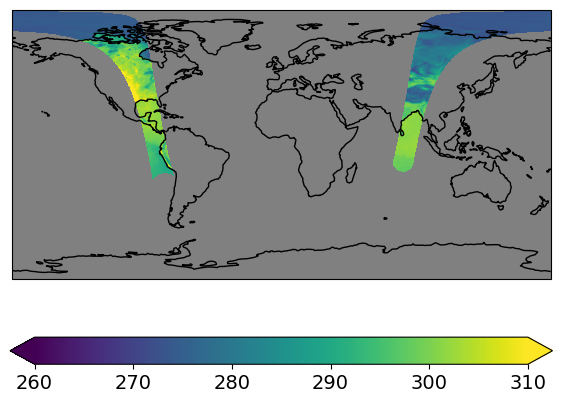

In [126]:
fig,ax = plot_global_map(skt[:,:,19],vmin=260,vmax=310,cmap='viridis',plt_colorbar=True)

Extract a geographic subset

In [127]:
#first rotate the longitudes to it plays better with cartopy

skt = np.roll(skt,720,axis=1)
lon = np.roll(lon,720)
lon[lon>180.] = lon[lon>180.] - 360.

lon_range = [-120.0,-70.0]
lat_range = [20.0,60.0]
time_index = 19

lon_ok = np.all([(lon >= lon_range[0]),(lon <= lon_range[1])],axis=0)
lat_ok = np.all([(lat >= lat_range[0]),(lat <= lat_range[1])],axis=0)

skt_subset = skt[lat_ok,:,time_index]
skt_subset = skt_subset[:,lon_ok]
shp = skt_subset.shape
num_pix_possible = shp[0]*shp[1]
print(f'Found {np.sum(np.isfinite(skt_subset))} valid pixels out of possible {num_pix_possible}')



Found 13333 valid pixels out of possible 32361


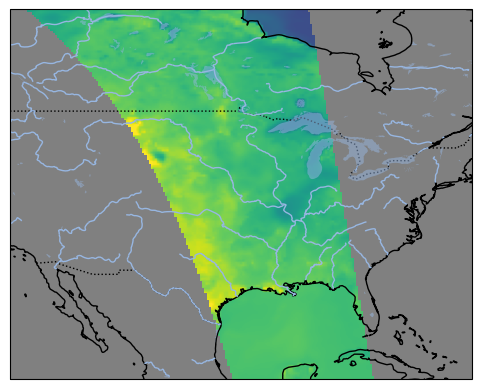

In [121]:


fig = plt.figure()
vmin = 260
vmax= 320
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([lon_range[0],lon_range[1],lat_range[0],lat_range[1]], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

cmap = 'viridis'
cmap_copy = plt.get_cmap(cmap).copy()
cmap_copy.set_bad('grey')
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

map = ax.imshow(skt_subset, cmap=cmap_copy, origin='lower', transform=ccrs.PlateCarree(),
                    norm=norm, extent=[lon_range[0],lon_range[1],lat_range[0],lat_range[1]])
    

plt.show()

In [128]:
output_path = Path('C:/Users/mears/jupyter_tutorials/downloads')

try:
    filename = retrieve_rss_radiance_var(
                rss_radiance_url_base = 'https://data.remss.com/radiance',
                year_to_get = 2013,
                month_to_get = 7,   
                day_to_get = 2,
                satellite = 'amsr2',
                footprint_diameter = 30,
                var_to_get = 'resamp_tbs',
                output_path = Path('C:/Users/mears/jupyter_tutorials/downloads'),
                verbose=True)
except Exception as err:
    print(err)
    print()

Retrieving: https://data.remss.com/radiance/AMSR2_30km/Y2013/M07/D02/amsr2_resamp_tbs_2013_07_02.030km.nc
Wrote: C:\Users\mears\jupyter_tutorials\downloads\amsr2_resamp_tbs_2013_07_02.030km.nc


In [129]:
print(f'Reading data from {filename}')

ds = xr.open_dataset(filename)
print(ds.keys())
tbs = ds['brightness_temperature'].values
lat = ds['latitude'].values
lon = ds['longitude'].values

Reading data from C:\Users\mears\jupyter_tutorials\downloads\amsr2_resamp_tbs_2013_07_02.030km.nc
KeysView(<xarray.Dataset>
Dimensions:                 (latitude: 721, longitude: 1440, hours: 24,
                             freq: 6, pol: 2)
Coordinates:
  * latitude                (latitude) float32 -90.0 -89.75 -89.5 ... 89.75 90.0
  * longitude               (longitude) float32 0.0 0.25 0.5 ... 359.5 359.8
  * hours                   (hours) datetime64[ns] 2013-07-02 ... 2013-07-02T...
  * freq                    (freq) float32 6.9 7.3 10.7 18.7 23.8 37.0
  * pol                     (pol) float64 0.0 1.0
Data variables:
    time                    (latitude, longitude, hours) datetime64[ns] ...
    brightness_temperature  (latitude, longitude, hours, freq, pol) float32 ...
Attributes: (12/39)
    Conventions:               CF-1.8
    standard_name_vocabulary:  CF Standard Name Table (v78, 21 September 2021)
    date_issued:               2022-10-01
    keywords_vocabulary:       NAS

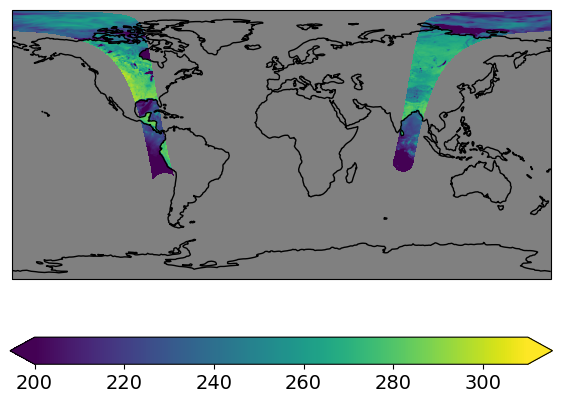

In [132]:
fig,ax = plot_global_map(tbs[:,:,19,4,1],vmin=200,vmax=310,cmap='viridis',plt_colorbar=True)